# Aprendizaje Basado en prototipos primero ejemplo

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.decomposition import PCA

### Dataset

In [2]:
# Transformación para normalizar los datos
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Cargar el dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [3]:
# Transformación para normalizar los datos
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Cargar el dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [27]:
len(train_loader)

938

In [28]:
len(test_loader)

157

### PrototypeNet

Esta arquitectura está definida por tres componentes principales:
- Autoencoder
  - Encoder : Convierte la entrada en una representación latente.
  - Decoder : Toma la representación latente y se contruye la imagen original. La salida se normaliza con Sigmoid para que esté en el rango [0,1].
- Capa de prototipos : Se definen 10 protipos, que son representaciones aprendibles en el espacio latente. Se inicializan aleatoriamente. Son parámetros entrenables, por lo que se optimizan durante el aprendizaje.
- Clasificador : Convierte las similitudes con los prototipos en predicciones sobre 10 clases (MNIST). Cada clase en MNIST se mapea a alguna combinación de prototipos.

In [4]:
class PrototypeNetwork(nn.Module):
    def __init__(self, num_prototypes=10, latent_dim=64, input_dim=28*28):
        super(PrototypeNetwork, self).__init__()
        # Codificador
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )

        # Prototipos
        self.prototypes = nn.Parameter(torch.randn(num_prototypes, latent_dim))

        # Clasificador
        self.classifier = nn.Linear(num_prototypes, 10)  # 10 clases en MNIST

        # Decodificador
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),  # Reconstruir la entrada original (tamaño 28x28 aplanado)
            nn.Sigmoid()  # Normalizar entre 0 y 1
        )

    def forward(self, x):
        # Codificador
        x = x.view(x.size(0), -1)  # Aplanar la imagen
        z = self.encoder(x)

        # Similitudes con prototipos
        prototype_distances = torch.cdist(z, self.prototypes, p=2)
        similarities = -prototype_distances  # Similitudes inversas a la distancia

        # Clasificador
        logits = self.classifier(similarities)

        # Reconstrucción (añadido)
        reconstruction = self.decoder(z)

        return logits, similarities, reconstruction


Medimos qué tan bien o mal está funcionando el modelo comparando su salida con el valor esperado.

In [5]:
def prototype_loss(logits, targets, similarities, prototypes, original_input, reconstruction, alpha=1.0, beta=0.1):
    # Pérdida de clasificación
    classification_loss = nn.CrossEntropyLoss()(logits, targets)

    # Pérdida de dispersión de prototipos (penaliza prototipos muy cercanos)
    prototype_distances = torch.cdist(prototypes, prototypes, p=2)
    diversity_loss = torch.mean(torch.triu(prototype_distances, diagonal=1))

    # Pérdida de reconstrucción
    reconstruction_loss = nn.MSELoss()(reconstruction, original_input.view(original_input.size(0), -1))

    # Pérdida total
    total_loss = classification_loss + alpha * (1 / diversity_loss) + beta * reconstruction_loss
    return total_loss


#### Entrenamiento

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PrototypeNetwork().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Ciclo de entrenamiento
for epoch in range(100):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward
        logits, similarities, reconstruction = model(images)

        # Calcular pérdida
        loss = prototype_loss(logits, labels, similarities, model.prototypes, images, reconstruction)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}")


Epoch 1, Loss: 1.2117911154019045
Epoch 2, Loss: 0.5161203926623757
Epoch 3, Loss: 0.42634856408592986
Epoch 4, Loss: 0.37827343542946934
Epoch 5, Loss: 0.34524906050167614
Epoch 6, Loss: 0.3240786833422525
Epoch 7, Loss: 0.30202845293385133
Epoch 8, Loss: 0.28934095838049584
Epoch 9, Loss: 0.27693650085153354
Epoch 10, Loss: 0.2652639807350854
Epoch 11, Loss: 0.2616031747192208
Epoch 12, Loss: 0.2529709356457694
Epoch 13, Loss: 0.24681612129595235
Epoch 14, Loss: 0.23850153210257163
Epoch 15, Loss: 0.23537229290649073
Epoch 16, Loss: 0.2327138472721775
Epoch 17, Loss: 0.22516588258273057
Epoch 18, Loss: 0.22299825080803462
Epoch 19, Loss: 0.21618108516499432
Epoch 20, Loss: 0.21483285585319056
Epoch 21, Loss: 0.21209195035416434
Epoch 22, Loss: 0.21030431863532137
Epoch 23, Loss: 0.20854843587382263
Epoch 24, Loss: 0.20073839877523594
Epoch 25, Loss: 0.19933242827399708
Epoch 26, Loss: 0.19825256607934102
Epoch 27, Loss: 0.19561812907520895
Epoch 28, Loss: 0.19448378477205855
Epoch 29

In [17]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        predictions = torch.argmax(logits[1], dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {correct / total * 100:.2f}%")

Test Accuracy: 1.48%


#### Visualización de las representaciones latentes (z) y los prototipos

Se presentan distribuidos en un espacio de dos dimensiones usando PCA (Análisis de Componentes Principales).

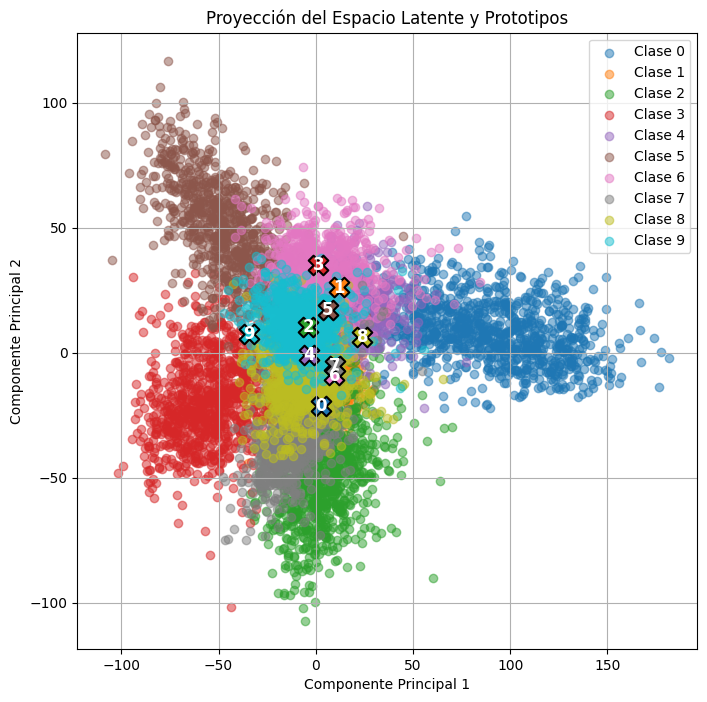

In [25]:
# Obtener las representaciones latentes (f(x)) y prototipos
model.eval()
latent_features = []
labels = []

with torch.no_grad():
    for images, lbls in test_loader: # train_loader
        images = images.to(device)
        z = model.encoder(images.view(images.size(0), -1))
        latent_features.append(z.cpu().numpy())
        labels.extend(lbls.numpy())

# Concatenar latentes
latent_features = np.vstack(latent_features)
labels = np.array(labels)

# Reducir dimensionalidad a 2D con PCA
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_features)
prototypes_2d = pca.transform(model.prototypes.detach().cpu().numpy())

# Graficar
plt.figure(figsize=(8, 8))
colors = plt.cm.tab10(np.linspace(0, 1, 10))  # 10 colores diferentes para las clases

for i in range(10):  # 10 clases en MNIST
    idx = labels == i
    plt.scatter(latent_2d[idx, 0], latent_2d[idx, 1], label=f"Clase {i}", alpha=0.5, color=colors[i])

# Graficar prototipos con colores y etiquetas diferentes
for j, (px, py) in enumerate(prototypes_2d):
    plt.scatter(px, py, color=colors[j % 10], marker="X", s=200, edgecolors="black", linewidth=1.5)
    plt.text(px, py, str(j), fontsize=12, fontweight="bold", ha='center', va='center', color="white")

plt.legend()
plt.title("Proyección del Espacio Latente y Prototipos")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.grid()
plt.show()


#### Heatmap

Se visualiza qué tan similares son las representaciones latentes de las imágenes con los prototipos.

- Si una fila tiene un valor alto en una columna, significa que esa imagen es similar a ese prototipo.
- Si hay valores bien distribuidos, los prototipos son diversos y representan diferentes grupos.
- Si todo es muy uniforme, puede indicar que los prototipos no están capturando bien la variedad de los datos.

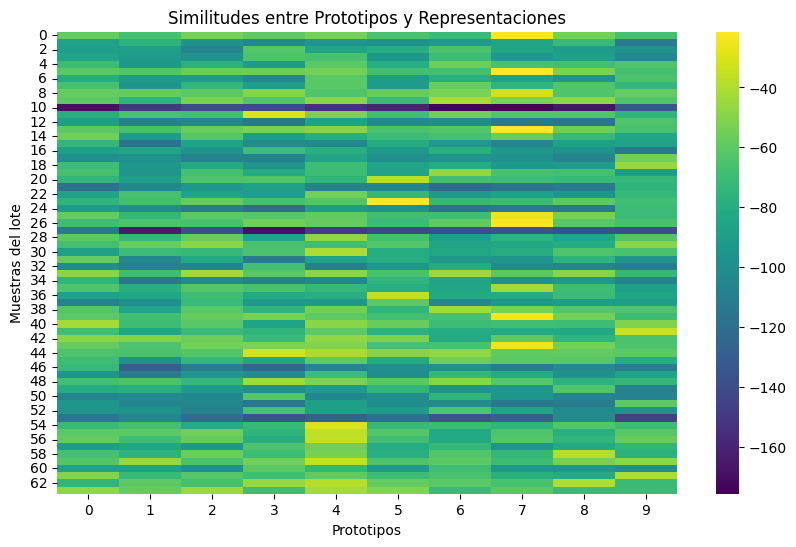

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular similitudes entre prototipos y un lote de datos
images, _ = next(iter(train_loader))
images = images.to(device)
z = model.encoder(images.view(images.size(0), -1))
similarities = -torch.cdist(z, model.prototypes, p=2).detach().cpu().numpy()

# Graficar la matriz de similitud
plt.figure(figsize=(10, 6))
sns.heatmap(similarities, cmap="viridis", annot=False)
plt.title("Similitudes entre Prototipos y Representaciones")
plt.xlabel("Prototipos")
plt.ylabel("Muestras del lote")
plt.show()


Se evalua la capacidad del modelo de reconstruir imágenes a partir de sus representaciones latentes. La idea es observar si la reconstrucción es lo suficientemente fiel a la imagen original o si el modelo está perdiendo detalles importantes.

Si las reconstrucciones son similares a las originales, significa que el modelo está aprendiendo una buena representación latente. Si no, puede ser necesario ajustar la arquitectura o la función de pérdida.

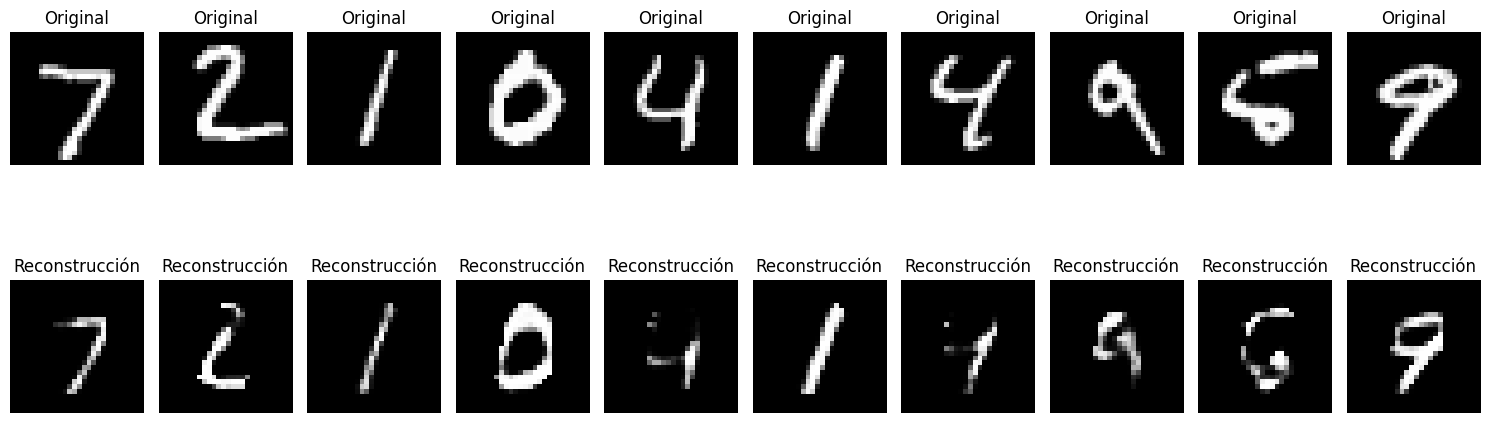

Ejemplo 1 - Prototype Scores:
Clase 0: 0.0000
Clase 1: 0.0000
Clase 2: 0.0000
Clase 3: 0.0000
Clase 4: 0.0000
Clase 5: 0.0000
Clase 6: 0.0000
Clase 7: 1.0000
Clase 8: 0.0000
Clase 9: 0.0000
-
Ejemplo 2 - Prototype Scores:
Clase 0: 0.0000
Clase 1: 0.0000
Clase 2: 1.0000
Clase 3: 0.0000
Clase 4: 0.0000
Clase 5: 0.0000
Clase 6: 0.0000
Clase 7: 0.0000
Clase 8: 0.0000
Clase 9: 0.0000
-
Ejemplo 3 - Prototype Scores:
Clase 0: 0.0000
Clase 1: 1.0000
Clase 2: 0.0000
Clase 3: 0.0000
Clase 4: 0.0000
Clase 5: 0.0000
Clase 6: 0.0000
Clase 7: 0.0000
Clase 8: 0.0000
Clase 9: 0.0000
-
Ejemplo 4 - Prototype Scores:
Clase 0: 1.0000
Clase 1: 0.0000
Clase 2: 0.0000
Clase 3: 0.0000
Clase 4: 0.0000
Clase 5: 0.0000
Clase 6: 0.0000
Clase 7: 0.0000
Clase 8: 0.0000
Clase 9: 0.0000
-
Ejemplo 5 - Prototype Scores:
Clase 0: 0.0000
Clase 1: 0.0000
Clase 2: 0.0000
Clase 3: 0.0000
Clase 4: 1.0000
Clase 5: 0.0000
Clase 6: 0.0000
Clase 7: 0.0000
Clase 8: 0.0000
Clase 9: 0.0000
-
Ejemplo 6 - Prototype Scores:
Clase 0: 0

In [20]:
# Seleccionar un lote de imágenes
test_images, _ = next(iter(test_loader))
test_images = test_images.to(device)

# Pasar las imágenes por el modelo
with torch.no_grad():
    logits, similarities, reconstructions = model(test_images)
    prototype_scores = F.softmax(logits, dim=1).cpu().numpy()  # Convertir a probabilidades

# Visualización de imágenes originales y reconstruidas
fig, axes = plt.subplots(2, 10, figsize=(15, 6))
for i in range(10):
    # Imagen original
    axes[0, i].imshow(test_images[i].cpu().squeeze(), cmap="gray")
    axes[0, i].axis("off")
    axes[0, i].set_title("Original")

    # Reconstrucción
    axes[1, i].imshow(reconstructions[i].cpu().view(28, 28), cmap="gray")
    axes[1, i].axis("off")
    axes[1, i].set_title("Reconstrucción")

plt.tight_layout()
plt.show()

# Imprimir las probabilidades de cada clase por cada ejemplo
for i in range(10):
    print(f"Ejemplo {i+1} - Prototype Scores:")
    for j, prob in enumerate(prototype_scores[i]):
        print(f"Clase {j}: {prob:.4f}")
    print("-")

## Primeros ataques


### FGSM
El FGSM (Fast Gradient Sign Method) funciona generando pequeñas perturbaciones en la entrada para engañar al modelo. Se basa en calcular el gradiente de la pérdida con respecto a la entrada y añadir una perturbación controlada.

Definir la Función de Ataque FGSM

In [11]:
def fgsm_attack(model, images, labels, epsilon):
    images = images.clone().detach().to(device)
    labels = labels.clone().detach().to(device)

    images.requires_grad = True

    # Obtener la salida del modelo
    outputs = model(images)

    # Si el modelo devuelve una tupla, tomamos el primer valor
    if isinstance(outputs, tuple):
        outputs = outputs[0]  # Probablemente sean los logits

    loss = torch.nn.functional.cross_entropy(outputs, labels)

    # Calcular gradientes de la pérdida con respecto a la imagen
    model.zero_grad()
    loss.backward()

    # Generar la perturbación adversarial
    perturbation = epsilon * images.grad.sign()

    # Crear la imagen adversaria
    adv_images = images + perturbation
    adv_images = torch.clamp(adv_images, 0, 1)  # Normalización

    return adv_images


Aplicar el Ataque a un Lote de Datos

In [12]:
outputs = model(images)
print(type(outputs))  # ¿Es una tupla o un tensor?
print(len(outputs))   # Si es una tupla, ¿cuántos elementos tiene?


<class 'tuple'>
3


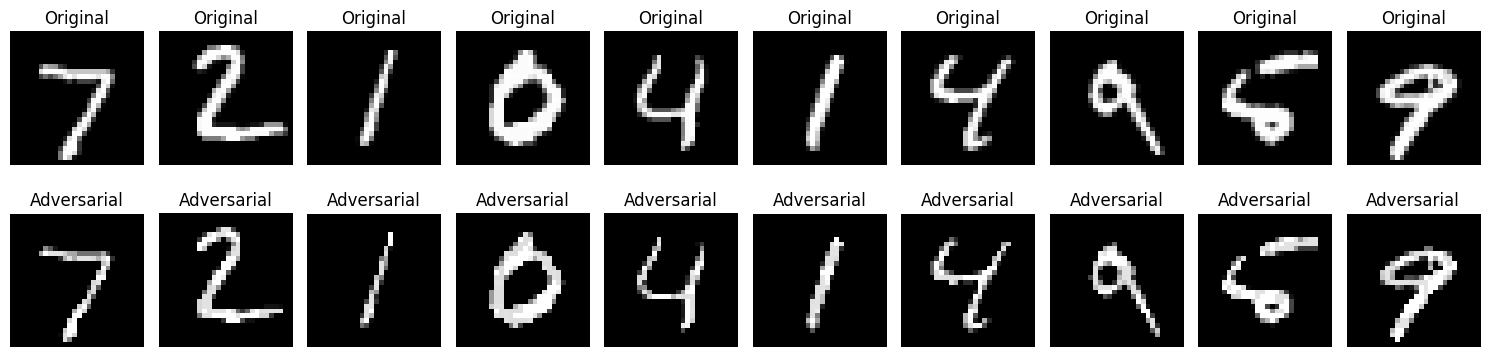

In [13]:
import matplotlib.pyplot as plt

# Obtener un lote de imágenes y etiquetas
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

# Aplicar FGSM con epsilon = 0.1
epsilon = 0.1
adv_images = fgsm_attack(model, images, labels, epsilon)

# Visualizar imágenes originales vs adversarias
fig, axes = plt.subplots(2, 10, figsize=(15, 4))

for i in range(10):
    # Imagen original
    axes[0, i].imshow(images[i].cpu().squeeze(), cmap="gray")
    axes[0, i].axis("off")
    axes[0, i].set_title("Original")

    # Imagen adversarial
    axes[1, i].imshow(adv_images[i].cpu().detach().squeeze(), cmap="gray")
    axes[1, i].axis("off")
    axes[1, i].set_title("Adversarial")

plt.tight_layout()
plt.show()


Evaluar el Impacto del Ataque

In [14]:
original_preds = model(images)[0].argmax(dim=1)
adv_preds = model(adv_images)[0].argmax(dim=1)


# Comparar resultados
print("Etiquetas reales:   ", labels[:10].cpu().numpy())
print("Predicciones normales: ", original_preds[:10].cpu().numpy())
print("Predicciones adversarias:", adv_preds[:10].cpu().numpy())


Etiquetas reales:    [7 2 1 0 4 1 4 9 5 9]
Predicciones normales:  [7 2 1 0 4 1 4 9 5 9]
Predicciones adversarias: [7 2 1 4 9 1 4 9 5 9]
